# SHAP for HEP data 
## Events classification using DNN
***

Raquel Pezoa, Luis Salinas, Claudio Torres (UV, CCTVal, Valparaíso Chile)


This is a preliminary version.

In [13]:
import pandas as pd
import shap
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam
import talos
from talos.utils import lr_normalizer
from talos.metrics.keras_metrics import f1score, precision, recall 
from talos.utils import hidden_layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense

from talos.utils.best_model import best_model, activate_model

import matplotlib.pyplot as plt
import numpy as np

import mplhep as hep

## Data
***
- Data is obtained from: https://www.openml.org/d/23512
- Problem: binary classification of HEP events, indentify signal from background.
 - signal: $gg \rightarrow H^0 \rightarrow W^{\mp} H^{\pm} \rightarrow W^{\mp} W^{\pm} h^0 \rightarrow W^{\mp} W^{\pm} b \bar{b}$. Check [here](https://www.nature.com/articles/ncomms5308).

In [2]:
seed_=420
# Read data file
df = pd.read_csv("../data/higgs/phpZLgL9q.csv")
df.rename(columns = {'class': 'label'}, inplace = True)
# Removing last row containinng "?" values
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df = df.apply(pd.to_numeric)
# Pandas dataframe for correlation matrix without label column
df_corr = df.drop('label', inplace=False, axis=1)

# Scaling data
y = df["label"]
X = df.iloc[:,1:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)


# Training, validation, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size=0.2, random_state=seed_)

## Talos and Keras
*****
- In this notebook just using one configuration to be executed in any laptop

In [3]:
n_exp = 7
p = {'lr': [1],
     'activation':['relu'],
     'optimizer': [Adam],
     'loss': ['binary_crossentropy'],
     'shapes': ['brick'],
     'first_neuron': [64],
     'hidden_layers':[4],
     'dropout': [0],
     'batch_size': [512],
     'epochs': [100],
     'last_activation': ['sigmoid'],
    'weight_regulizer': [None]}


# define the input model
def higgs_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    activation=params['activation']))

    model.add(Dropout(params['dropout']))

    hidden_layers(model, params, 1)

    model.add(Dense(1, activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=[f1score,precision, recall])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=(x_val, y_val))
    return out, model


scan_object = talos.Scan(x = X_train.to_numpy(), 
                         y = y_train.to_numpy(),
                         x_val=X_val.to_numpy(),
                         y_val=y_val.to_numpy(),
                         params=p,
                         model=higgs_model,
                         experiment_name='higgs'+str(n_exp))

100%|██████████| 1/1 [00:46<00:00, 46.55s/it]


In [5]:
best_idx = scan_object.best_model(metric='val_f1score', asc=True) 
model_id = scan_object.data['val_f1score'].astype('float').argmax() 
model = activate_model(scan_object, model_id)

## Prediction
***

In [9]:
y_pred_train = best_idx.predict(X_train)
y_pred_test = best_idx.predict(X_test)
y_pred_val = best_idx.predict(X_val)

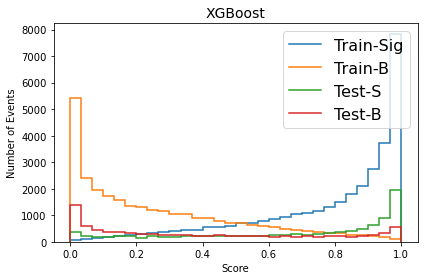

In [10]:
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("XGBoost", fontsize=14)
hep.histplot([h_signal_train,h_back_train, h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Train-Sig", "Train-B", "Test-S", "Test-B"])
axs.legend(fontsize=16)
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")

plt.tight_layout()
plt.show()
#plot_name = "dist_plots/dnn/score_dist_{}_test.png".format(out_name)
#plt.savefig(plot_name)



In [11]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score as f1s

fpr, tpr, ths = roc_curve(y_test,  y_pred_test)
auc_ = auc(fpr, tpr)
f1 = f1s(y_test,  (y_pred_test>.5))
prec = precision_score(y_test,  (y_pred_test>.5))
rec = recall_score(y_test,  (y_pred_test>.5))
acc = accuracy_score(y_test,  (y_pred_test>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.68  -- prec: 0.67  -- recall: 0.69  -- acc: 0.66


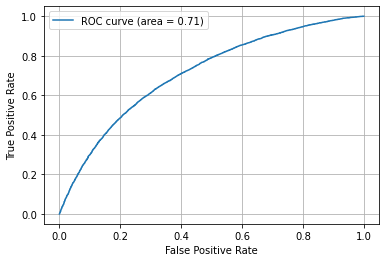

In [12]:
#create ROC curve
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

## SHAP
***

In [14]:
start_time = time()
explainer = shap.DeepExplainer(model, X_test.to_numpy())
shap_values = explainer.shap_values(X_test.to_numpy())
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)

Elapsed time: 2096.44645 seconds.


In [15]:
# print the JS visualization code to the notebook
shap.initjs()

### Force plots
*****

In [16]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][:1],  X_test.iloc[:1])

In [18]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][:100],  X_test.iloc[:100])

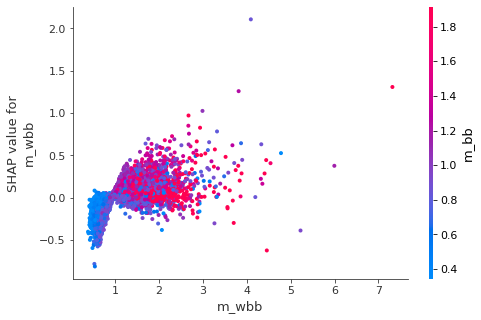

In [19]:
shap.dependence_plot("m_wbb", shap_values[0],  X_test)

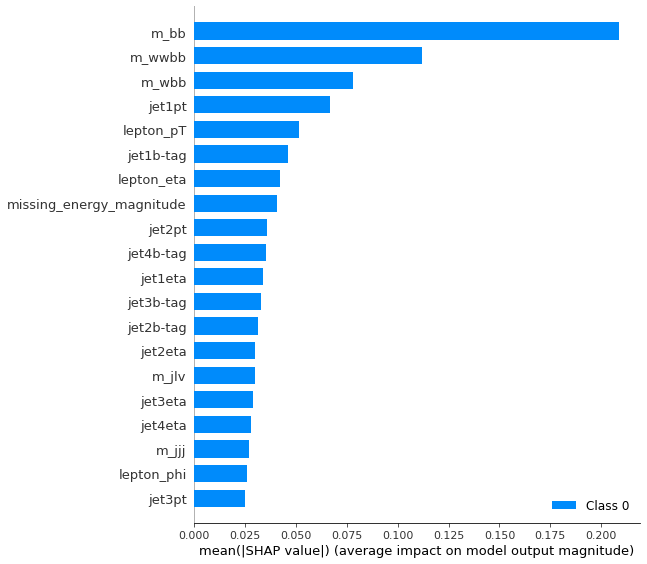

In [20]:
shap.summary_plot(shap_values, X_test, plot_type="bar")